# Fitting S+D model to ablation experiment

- Need to first run Cluster_Fit_SD_model_Exp.py, to obtain correct fits
- This notebook Figures 3B-D, Supplementary Fig 4G-I

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle

sys.path.append("../../simulator/")
sys.path.append("../../fitting/")


from tissue import *
import tissplot as tplt
import matplotlib.path as mplPath
import analysis
import datasets as ds 
import tiss_optimize as topt
import sim_model

expdata = ds.load_object('../../experiment/ablation.pkl')

def death(t, tscale = 1, dshift = -1, tmin = -3, b1 = 3.2553e-2, b2 = 8.7969e-1, bx = 0.5240):
    t = t/tscale + dshift
    if type(t) == int or type(t) == float:
        t = np.array([t])
    y = np.zeros(len(np.array(t)))
    y[t >= 0] = np.exp(-bx*t[t >= 0])
    y[t  < 0] = np.exp(b1*(t[t < 0] - tmin))*(1 - np.exp(-b2*(t[t < 0] - tmin)))/np.exp(-tmin*b1)/(1 - np.exp(tmin*b2))
    y[t < tmin] = 0.0
    return y


from matplotlib import rcParams



In [4]:
#Extract the best fit simulated data
i = -1

s0 = topt.sim_anneal(sim_model.SD_mech_switch, 
                     {'deathscale': -0.95238095, 'Ahigh': 1.7, 'tadiv': 30, 'r': 0.2}, 
                     params = {'tau': 500.0, 'hilln': 10, 
                               'L': 15, 'tscale': 65, 'rho': 0.9}, simtype = 'a',
                exp_file = '../../experiment/ablation.pkl',  exp_prefix = 'exp', tshift = -5.0,
                   metrics = [{'cost': 'cost_prd', 'dist_metric': 'ksd', 
                               'dist': ['basalCS'],
                               'quantity': ['density', 'divrate'], 'qmetric': 'pls'}, {'dist': ['totalCS']}],
                   move_seed = i, use_linear = ['Ahigh', 'tadiv', 'r'],
                   move_sizes     = {'deathscale': 1.05, 'Ahigh': 0.05, 'tadiv': 5, 'r': 0.05}, 
                   free_param_min = {'deathscale': -3.0,  'Ahigh': 1.0, 'tadiv': 5, 'r': 0.05}, 
                   free_param_max = {'deathscale': -0.5,  'Ahigh': 2.2, 'tadiv': 150, 'r': 0.55},
                   toCalculate = ['pers', 'supraCS'])


s0.load_existing(1500, 225, 'exp_SD0D/')

deathprofile = np.ones(1500)*(500*0.25)**(-1)
deathprofile[ds.exp2simTimes(6,  65.0, 5):] = (500*0.3)**(-1)
deathprofile[ds.exp2simTimes(11, 65.0, 5):] = (500*0.5)**(-1)

sim_data = s0.get_best_fit('cost_prd_ksd_bas_av_pls_dens_dr', 1500, 225, 
                           savefolder = 'exp_SD0D/', nseeds = 20, save_results = True,
                           norm_by_control = ['density', 'divrate'], shed = 0.0, shed_profile = deathprofile)


exp_data = s0.exp_data

ds.save_object({'sim_data': sim_data, 'exp_data': exp_data}, 'best_exp_fits.pkl')

Best fit: index                                       39.000000
deathscale                                  -1.102500
Ahigh                                        1.250000
tadiv                                       20.000000
r                                            0.300000
hilln                                       10.000000
tau                                        500.000000
L                                           15.000000
tscale                                      65.000000
rho                                          0.900000
maxseed                                      4.000000
cost_prd_ksd_bas_av_pls_dens_dr             -3.037485
cost_prd_ksd_bas_av_pls_dens_dr:shed         0.000000
cost_prd_ksd_bas_av_pls_dens_dr:tscale      65.000000
cost_prd_ksd_bas_av_pls_dens_dr:density      0.009903
cost_prd_ksd_bas_av_pls_dens_dr:divrate      7.072552
cost_prd_ksd_bas_av_pls_dens_dr:basalCS      0.684669
shed                                         0.000000
cost_lsqd_tot     

In [ ]:
# Re-run the best fit simulations to have more simulated data for plotting

s0.runSA(ncells = 225, tsteps = 1500, seeds = np.arange(20), savefolder = 'exp_SD0D/',
        tscalevals = 65, shedvals = None,
        use_saved_metrics = False, ncores = 5, save_every = 5, mergefirst = False, 
        SAsteps = 0, T0 = 0.01, start_idx = None,
        sim_args = {'p0': 3.5}, norm_by_control = ['density', 'divrate'], 
        init_params = {'relaxsteps': 1500, 'homeosteps': 2000, 'ctrsteps': 2000, 
                        'kill_fn': death, 'kill_params': {'dshift': -6}})

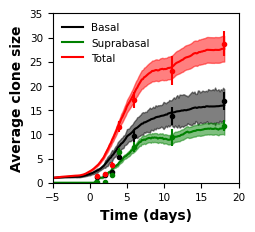

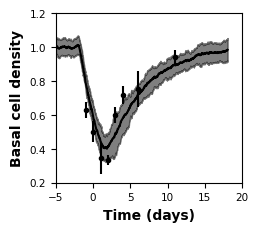

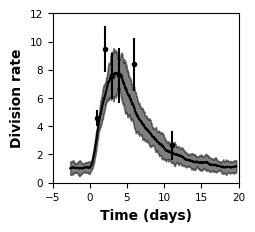

In [3]:
#Plot best fit simulations

# Set global font properties
rcParams['font.family'] = 'sans-serif'

# Set global font size for all axes
rcParams['axes.labelsize'] = 10
rcParams['axes.labelweight'] = 'bold'
rcParams['xtick.labelsize'] = 7.5
rcParams['ytick.labelsize'] = 7.5
rcParams['legend.fontsize'] = 7.5
rcParams['font.size'] = 7.5  # General font size
rcParams['text.usetex'] = False
rcParams['svg.fonttype'] = 'none'
rcParams['lines.markersize']  = 3
rcParams['lines.linewidth']  = 1.5


plt.figure(figsize=(2.4,2.2))
plt.margins(x=0) 
plt.margins(y=0) 
ds.plot_quantity('basalCS', sim_data, exp_data, sim_data.tscalevals[0],
                 ylabel = 'Average clone size', plot_seeded = False, prelabel = 'bas: ', bootSEs = True, errmult = 1.96)
ds.plot_quantity('supraCS', sim_data, exp_data, sim_data.tscalevals[0],
                 ylabel = 'Average clone size', plot_seeded = False, color = 'g', prelabel = 'sup: ', errmult = 1.96)
ds.plot_quantity('totalCS', sim_data, exp_data, sim_data.tscalevals[0],
                 ylabel = 'Average clone size', plot_seeded = False, color = 'r', prelabel = 'tot: ', errmult = 1.96)
plt.legend(['Basal', 'Suprabasal', 'Total'], frameon=False)
plt.xlim([-5,20])
plt.ylim([0, 35])
plt.xticks(np.arange(-5,21,5))
plt.savefig('Fig3D_mean_clone_size.svg', dpi = 400, bbox_inches='tight')

plt.figure(figsize=(2.4,2.2))
plt.margins(x=0) 
plt.margins(y=0) 
ds.plot_quantity('density', sim_data, exp_data, sim_data.tscalevals[0],
                 ylabel = 'Basal cell density', plot_seeded = False, prelabel = 'bas: ', errmult = 1.96)
plt.gca().get_legend().remove()
plt.xticks(np.arange(-5,21,5))
plt.xlim([-5,20])
plt.ylim([0.2,1.2])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0,1.2])
plt.savefig('Fig3B_density.svg', dpi = 400, bbox_inches='tight')

plt.figure(figsize=(2.4,2.2))
plt.margins(x=0) 
plt.margins(y=0) 
ds.plot_quantity('divrate', sim_data, exp_data, sim_data.tscalevals[0],
                 ylabel = 'Division rate', plot_seeded = False, prelabel = 'bas: ', errmult = 1.96, sim_shift = 2.0,
                 sim_slice = [25, -25])
plt.gca().get_legend().remove()
plt.xticks(np.arange(-5,21,5))
plt.xlim([-5,20])
plt.ylim([0,12])
plt.savefig('Fig3C_divrate.svg', dpi = 400, bbox_inches='tight')



In [4]:
# Getting the Control persistence

ctr_params = sim_data.sim_params.copy()
ctr_params.pop('deathscale')
ctr_params.pop('tscale')
ctr_params


c0 = topt.optimizer(sim_model.SD_mech_switch, 
                     {'tadiv': 20.0}, params = ctr_params, simtype = 'h',
                exp_file = '../../experiment/ablation.pkl',  exp_prefix = 'ctr', tshift = -5.0,
                   metrics = [{'cost': 'cost_prd', 'dist': [], 'exclude_times': {},
                               'quantity': ['pers'], 'qmetric': 'pls'}],
                   move_seed = i, toCalculate = ['pers', 'supraCS', 'basalCS'])


c0.optimise(ncells = 225, tsteps = 1500, seeds = np.arange(5), savefolder = 'exp_SD0D/',
           tscalevals = sim_data.sim_params['tscale'], shedvals = 0,
           use_saved_metrics = False, ncores = 1, save_every = 5, mergefirst = False,
           sim_args = {'p0': 3.5}, init_params = {'relaxsteps': 1500, 'homeosteps': 2000})


csim_data = c0.get_sim_data(0, 1500, 225, 'exp_SD0D/', nseeds = 5,
            tscalevals = [sim_data.sim_params['tscale']], shedvals = [0]).get_instance()

Running for: {'Ahigh': np.float64(1.25), 'L': np.int64(15), 'hilln': np.float64(10.0), 'r': np.float64(0.3), 'rho': np.float64(0.9), 'tadiv': np.float64(20.0), 'tau': np.float64(500.0)}
File already exists: hrun_SD_mech_switch_t_1500_n_225_Ahigh_1.25_L_15.0_hilln_10.0_r_0.3_rho_0.9_tadiv_20.0_tau_500.0_seed_0.pkl
File already exists: hrun_SD_mech_switch_t_1500_n_225_Ahigh_1.25_L_15.0_hilln_10.0_r_0.3_rho_0.9_tadiv_20.0_tau_500.0_seed_1.pkl
File already exists: hrun_SD_mech_switch_t_1500_n_225_Ahigh_1.25_L_15.0_hilln_10.0_r_0.3_rho_0.9_tadiv_20.0_tau_500.0_seed_2.pkl
File already exists: hrun_SD_mech_switch_t_1500_n_225_Ahigh_1.25_L_15.0_hilln_10.0_r_0.3_rho_0.9_tadiv_20.0_tau_500.0_seed_3.pkl
File already exists: hrun_SD_mech_switch_t_1500_n_225_Ahigh_1.25_L_15.0_hilln_10.0_r_0.3_rho_0.9_tadiv_20.0_tau_500.0_seed_4.pkl
Metric: cost_av_pls_pers Best cost: -2.0102849973510994 tscale: 65.0 shed: 0.0
Saving search space to: hfits_ctr_ablation_index_0_SD_mech_switch_t_1500_n_225_Ahigh_L_hil

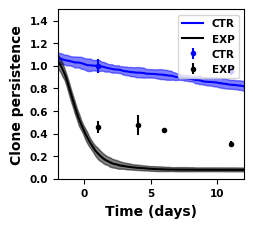

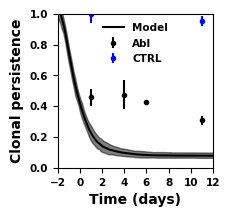

In [17]:

rcParams['lines.markersize']  = 3
rcParams['lines.linewidth']  = 1.5

ctr_data = ds.exp_dataset('../../experiment/ablation.pkl', prefix = 'ctr', suffix = '', toCalculate = s0.toCalculate)

pers0 = np.mean(csim_data.quantities['pers'],0)[ds.exp2simSkippedTimes(1, sim_data.tscalevals[0], 5, 10)]

plt.figure(figsize=(2.4,2.2))
plt.margins(x=0) 
plt.margins(y=0) 
ds.plot_quantity('pers', csim_data, ctr_data, sim_data.tscalevals[0], color = 'b',
                 ylabel = 'Clone persistence', plot_seeded = False, prelabel = 'CTR',
                 sim_mult = 1/pers0, errmult = 1.96)
ds.plot_quantity('pers', sim_data, exp_data, sim_data.tscalevals[0],
                 ylabel = 'Clone persistence', plot_seeded = False, prelabel = 'EXP',
                 sim_mult = 1/pers0, errmult = 1.96)
plt.xlim([-2,12])
plt.ylim([0,1.5])
#plt.savefig('SFig4D_persistence.pdf', dpi = 400)

plt.figure(figsize=(2.0,2.0))
plt.margins(x=0) 
plt.margins(y=0) 
ds.plot_quantity('pers', sim_data, exp_data, sim_data.tscalevals[0],
                 ylabel = 'Clonal persistence', plot_seeded = False, prelabel = 'EXP: ',
                 sim_mult = 1/pers0, errmult = 1.96)
ds.plot_quantity('pers', None, ctr_data, sim_data.tscalevals[0], color = 'b',
                 ylabel = 'Clonal persistence', plot_seeded = False, prelabel = 'CTR: ',
                 sim_mult = 1/pers0, errmult = 1.96)


plt.legend(['Model', 'Abl', 'CTRL'], frameon=False)
plt.xlim([-2,12])
plt.xticks(np.arange(-2,13,2))
plt.ylim([0,1.0])
plt.savefig('SFig4D_persistence.pdf', bbox_inches='tight')


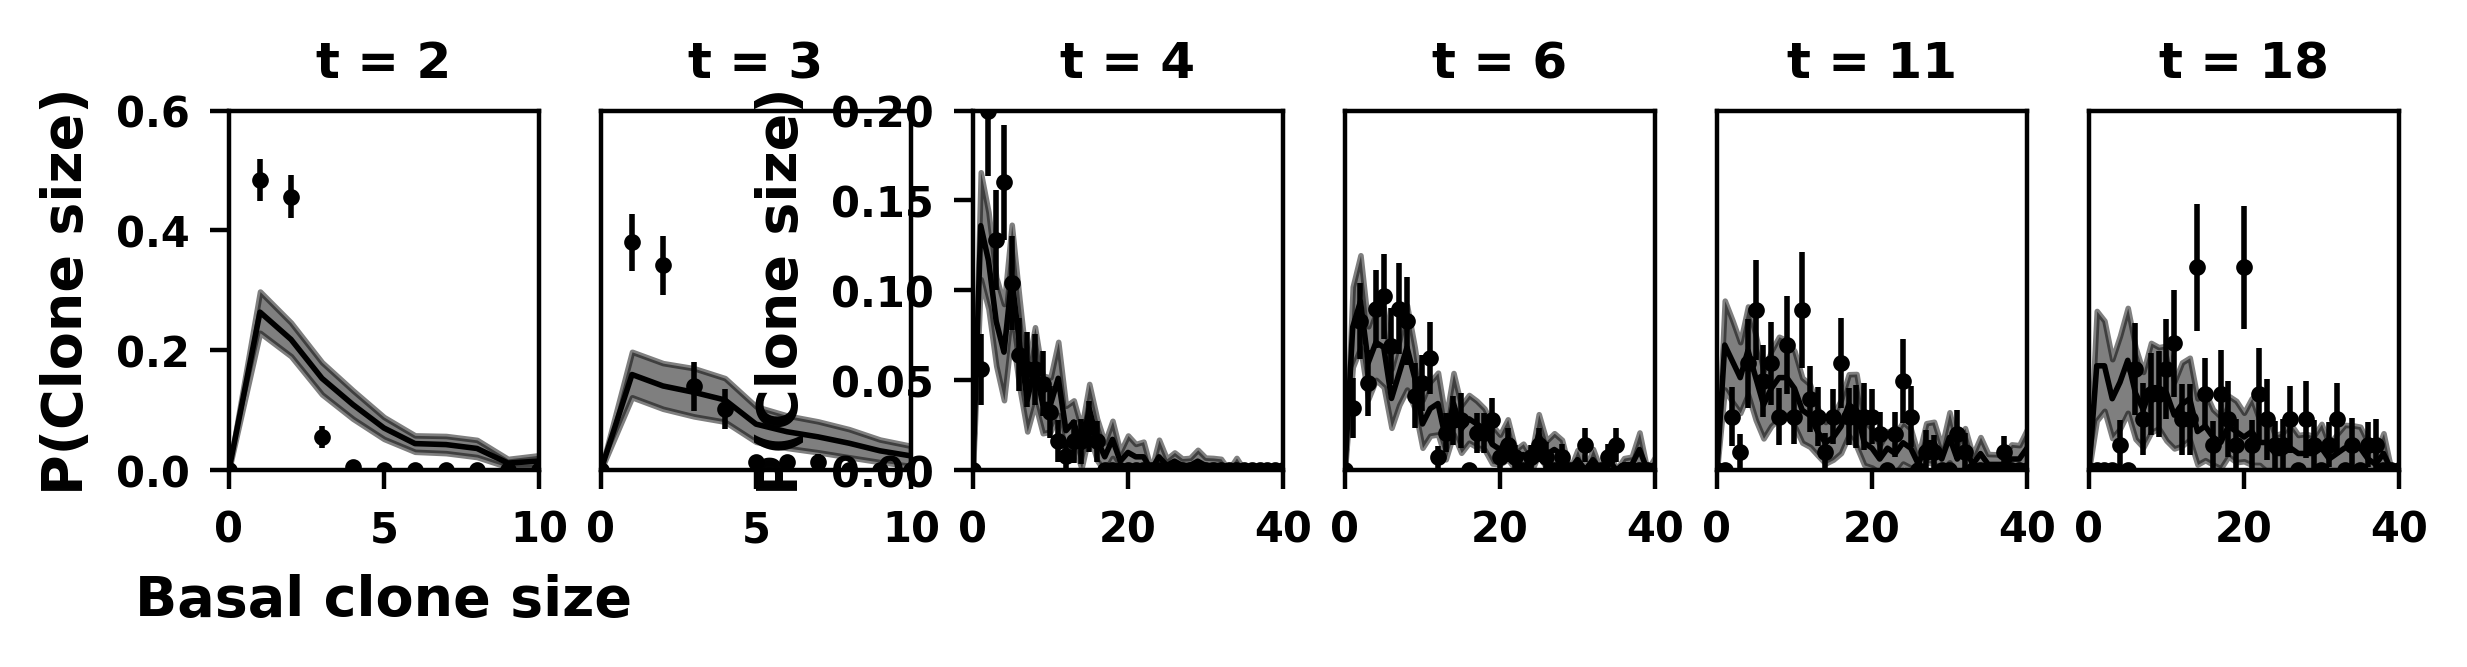

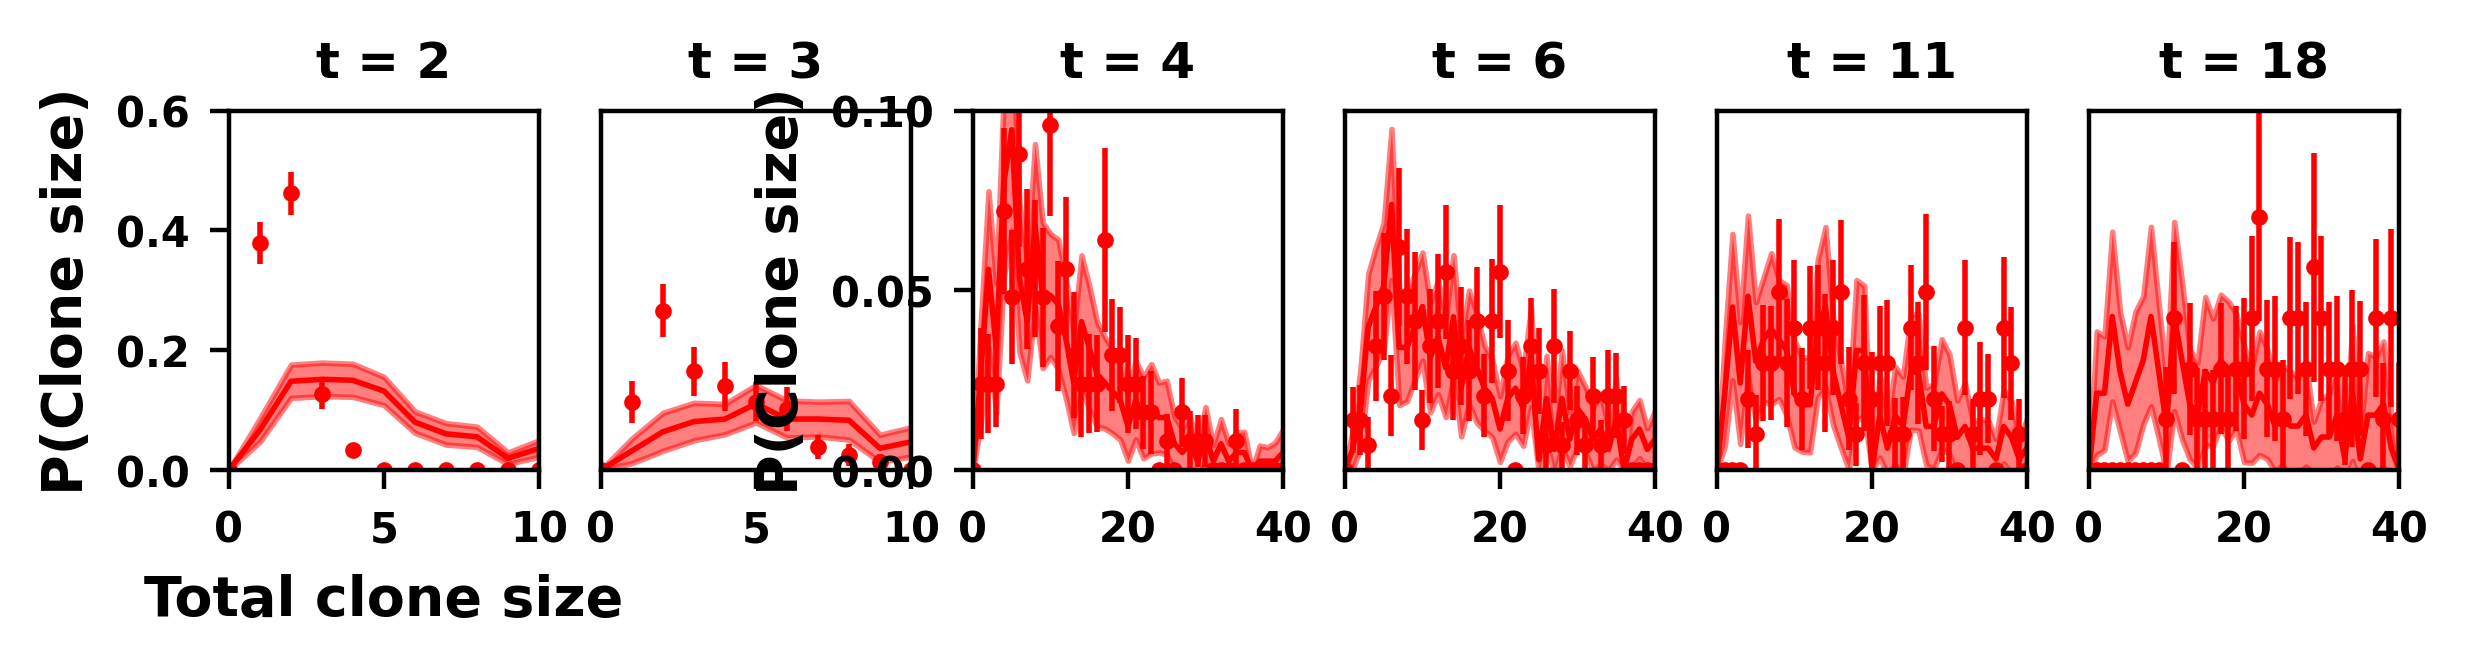

In [5]:
# Set global font properties
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'bold'

# Set global font size for all axes
rcParams['axes.labelsize'] = 10
rcParams['axes.labelweight'] = 'bold'
rcParams['xtick.labelsize'] = 7.5
rcParams['ytick.labelsize'] = 7.5
rcParams['legend.fontsize'] = 7.5
rcParams['font.size'] = 7.5  # General font size
rcParams['text.usetex'] = False
rcParams['svg.fonttype'] = 'none'
rcParams['lines.markersize']  = 2.0
rcParams['lines.linewidth']  = 1.0
rcParams['axes.titleweight'] =  'bold'

axs = ds.plot_dist('basalCS', sim_data, exp_data, subtimes= np.arange(1,7), maxbin = 10, 
                   cdf = False, xlabel= 'Basal clone size', ylabel = 'P(Clone size)', bootSEs = True, errmult = 1,
                   overhang_in_last=False, noticks=False, ymax = 0.6, 
                   xticks = [0, 5, 10], im_width = 7, maxbin2 = 40,
                   yy2 = 2, ymax2 = 0.2, xticks2 = [0, 20, 40])
plt.savefig('FigS4B_basal_clone_size.pdf', dpi = 400, bbox_inches='tight')


axs = ds.plot_dist('totalCS', sim_data, exp_data, subtimes= np.arange(1,7), maxbin = 10, 
                   cdf = False, xlabel= 'Total clone size', ylabel = 'P(Clone size)', bootSEs = True, errmult = 1,
                   overhang_in_last=False, noticks=False, ymax = 0.6,  color = 'r',
                   xticks = [0, 5, 10], im_width = 7, maxbin2 = 40,
                   yy2 = 2, ymax2 = 0.1, xticks2 = [0, 20, 40], yticks2 = [0, 0.05, 0.1])
plt.savefig('FigS4B_total_clone_size.pdf', dpi = 400, bbox_inches='tight')